<img src="../static/oADMET-color-tagline.png" width="400">

# OpenADMET Showcase: Predicting ADME activity profile against CYP3A4

## Introduction
Welcome to OpenADMET, a framework for computational modeling in ADMET! This includes:
- curating data for an ADMET endpoint of interest
- training and comparing a series of machine learning models
- inferring with those models on an unseen set of molecules.  

The aim of this showcase notebook is to highlight the key capabilities of the framework for a basic use-case: predicting activity of small molecules against a common anti-target in drug delivery, CYP3A4.

## Outline
1. Data Curation
2. Model Training
3. Model Comparison
4. Model Inference
5. Next steps

## 1. Data Curation

Data tends to be scarce and sparse in the biochemistry world.  

Due to the time consuming and costly nature of lab experiments, it is not always feasible to generate the tens to hundreds of thousands of data points potentially needed to train machine learning models (depending on the complexity of the model and the nature of the data).   

We therefore want to be able to supplement our model training with data from external, publicly available sources, such as [PubChem BioAssay](https://pubchem.ncbi.nlm.nih.gov/docs/bioassays), [ChEMBL](https://www.ebi.ac.uk/chembl/), etc. 

To make these datasets amenable to training, they have to be acquired, processed, and cleaned. This protocol will walk you through the necessary **bare minimum** data transformation and cleaning so that we can train our CYP3A4 inhibition model.

### CYP3A4 inhibition Data in ChEMBL

ChEMBL is one of the most widely used publicly available bioactivity databases. It aggregates experimental data from the literature, including assays measuring enzyme inhibition, receptor binding, and more. For CYP3A4, the relevant data is typically in the form of:

> **$IC_{50}$** – the concentration of a compound required to inhibit 50% of CYP3A4 activity. Often expressed on a logarithmic scale as $pIC_{50} = -\log10(IC_{50} (M))$.

> **$K_i$** – the inhibition constant, often derived from enzyme kinetics experiments.

> **Percent inhibition** – sometimes assays report only the percentage of enzyme activity inhibited at a given concentration. These are often less useful than "Dose-response" measurements that assay the behaviour of an enzyme under a variety of substrate concentrations.

For now we will limit ourselves to **$IC_{50}$ measurements** as they most closely represents what we are trying to predict: CYP inhibition.

Most data in ChEMBL comes from published assays, each linked to a documented assay ID, a compound ID, and an experimental value. Importantly, the same compound can appear in multiple assays with slightly different values depending on assay conditions (e.g., substrate type, enzyme source, assay format).


## How is data in ChEMBL organised

ChEMBL stores bioactivity data in a relational schema that is accessible via its web interface, REST API, or downloadable SQL databases.  The most relevant tables/fields for us today are the `target_id`, the `pchembl_value` and the `standard_type`


Luckily for you we provide the tools to pull in data from ChEMBL easily in the [OpenADMET Toolkit](https://github.com/OpenADMET/openadmet-toolkit). We will use this tooling here to pull our activity data for CYP3A4 inhibition.  


### Disclaimer

There is no real one-size-fits-all approach to data curation given the variety of use cases. Some experimentation and iteration 
may be necessary.  

Additionally this represents the **MINIMUM** level of curation needed to get a dataset like this fed into a machine learning model.  

Additional processing steps dependent on the actual values (activity based curation) such as normalization, outlier detection etc. are likely required to get build the best models possible.

### Using ChEMBL Target Curators 

[OpenADMET Toolkit](https://github.com/OpenADMET/openadmet-toolkit) provides a number of `Curators` to pull data from the ChEMBL database.

Some examples are listed here

> `PermissiveChEMBLTargetCurator`: Curates activity data for a given ChEMBL target with a distinct ChEMBL target ID (e.g CHEMBL340 for CYP3A4)

> `SemiQuantChEMBLTargetCurator`: Curates activity data for a given ChEMBL target including semi-quantitative data (<, <=, >=, =)

> `MICChEMBLCurator`: Curates MIC e.g for bacterial hosts, fungal hosts, etc. 

> `HepatotoxicityChEMBLCurator`: Curates hepatotoxicity data.

> etc.


This curator will now pull all activity measurements that have a `pChEMBL` value. Having a pChEMBL value gives a moderate amount of confidence that the datapoint is a relevant dose response assay and does not fall outside typical assay ranges. See the [ChEMBL docs](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-pchembl) for more information on the curation process behind pChEMBL

We can use the `PermissiveChEMBLTargetCurator` to pull in our CYP3A4 data, which only requires that the user specify:
1. `chembl_version` - the version of ChEMBL database to pull from
2. `target_id` - the ChEMBL ID of the target protein
3. `standard_type` - the type of activity we're interested in, e.g. IC50, EC50, etc.


```python
    from openadmet.toolkit.database.chembl import PermissiveChEMBLTargetCurator

    chembl_version = 35 # Specify which version of the ChEMBL database you're accessing. 35 is the latest version as of 7/1/25
    target = "CHEMBL340" # Specify the ChEMBL ID for CYP3A4. This needs to be looked up on the ChEMBL website.
    standard_type = "IC50" # We want IC50s only as looking at CYP inhibition

    # Instantiate the curator. This will automatically handle downloading the ChEMBL database
    curator = PermissiveChEMBLTargetCurator(chembl_version=chembl_version, 
                                            chembl_target_id=target, 
                                            standard_type=standard_type, 
                                            require_pchembl=True, 
                                            require_units="uM")
    
    # Now that the ChEMBL SQL database has been downloaded, we can load the activity data into a dataframe, 
    cyp3a4_data_raw = curator.get_activity_data()
    cyp3a4_data_aggregated =  curator.aggregate_activity_data_by_compound()
```

This code can take a while to run as it needs to download the ChEMBL database. 

> **Luckily OpenADMET has pre-curated data on a number of ADMET relevant targets already** in our [Data Catalogs](https://github.com/OpenADMET/data-catalogs) repo. Check it out and explore the other ChEMBL data we have curated.

In [1]:
# NVAL_SKIP
# Only run this cell on google colab
# placeholder cell

In [2]:
# Here's some data we prepared earlier!
import pandas as pd
cyp3a4_data_agg = pd.read_parquet("https://github.com/OpenADMET/data-catalogs/raw/refs/heads/main/catalogs/activities/ChEMBL_pChEMBL_IC50/ChEMBL35_IC50/ChEMBL_IC50_CYP3A4_CHEMBL340_aggregated.parquet")

cyp3a4_data_agg.head()

,OPENADMET_CANONICAL_SMILES,OPENADMET_INCHIKEY,assay_id_count,standard_value_mean,standard_value_median,standard_value_std,pchembl_value_mean,pchembl_value_median,pchembl_value_std
330,CC(=O)N1CCN(C2=CC=C(OCC3COC(CN4C=CN=C4)(C4=CC=...,XMAYWYJOQHXEEK-UHFFFAOYSA-N,69,2733.243333,57.00,13530.805498,7.088551,7.24,0.896828
334,CC(=O)N1CCN(C2=CC=C(OC[C@H]3CO[C@](CN4C=CN=C4)...,XMAYWYJOQHXEEK-OZXSUGGESA-N,51,491.523137,55.10,2977.186038,7.256471,7.26,0.564591
2093,CCOC1=CC=C(N2C([C@@H](C)N(CC3=CC=CN=C3)C(=O)CC...,WQTKNBPCJKRYPA-OAQYLSRUSA-N,16,15625.000000,14600.00,10297.281195,4.927500,4.87,0.365340
3035,COC1=CC=C([C@@H]2SC3=CC=CC=C3N(CCN(C)C)C(=O)[C...,HSUGRBWQSSZJOP-RTWAWAEBSA-N,11,29885.145455,12000.00,35187.813220,5.112727,4.92,1.060604
3711,ClC1=CC=C(COC(CN2C=CN=C2)C2=CC=C(Cl)C=C2Cl)C(C...,BYBLEWFAAKGYCD-UHFFFAOYSA-N,10,2205.634000,850.57,2423.189645,6.322000,6.07,1.191281


### Exploring our dataset

Let's have a quick look at the distribution of our inhibition IC50s: 
> They are mostly centered in the weak binding range ($100\ \mu\text{M} - 1\ \mu\text{M}$).

> However, some compounds are quite potent inhibitors of CYP3A4 ($< 1 \mu\text{M}$) meaning that they will pose significant risk of causing drug-drug interactions. 

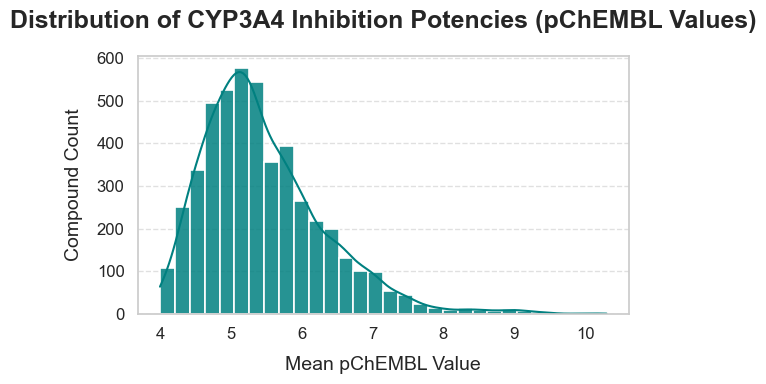

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))

# Histogram with KDE overlay
ax = sns.histplot(
    data=cyp3a4_data_agg,
    x="pchembl_value_mean",
    bins=30,
    kde=True,
    color="teal", 
    edgecolor="white",
    linewidth=1.2,
    alpha=0.85
)

# Titles and labels
ax.set_title("Distribution of CYP3A4 Inhibition Potencies (pChEMBL Values)", fontsize=18, weight="bold", pad=20)
ax.set_xlabel("Mean pChEMBL Value", fontsize=14, labelpad=10)
ax.set_ylabel("Compound Count", fontsize=14, labelpad=10)


# Make ticks bigger and easier to read
ax.tick_params(axis="both", labelsize=12)

# Subtle gridlines only on y-axis
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

### Final processing

Let's add some finishing touches. It's often nice to add a standard header to our dataset such that activity is standard across different datasets (`standard_value` provides this in ChEMBL).  

At OpenADMET, we often use `OPENADMET_LOGAC50` for this purpose.  

Let's also add a few columns describing our endpoint, `OPENADMET_ACTIVITY_TYPE` and target `Target`.

In [4]:
cyp3a4_data_agg["OPENADMET_ACTIVITY_TYPE"] = "IC50"
cyp3a4_data_agg["Target"] = "CYP3A4"
cyp3a4_data_agg["OPENADMET_LOGAC50"] = cyp3a4_data_agg["pchembl_value_mean"]

cyp3a4_data_agg.to_csv("cleaned_cyp3a4.csv", index=False)

## 2. Model Training
<div style="text-align: center">
<img src="static/anvil_diagram.png" alt="Anvil diagram" width="500"/>  
</div>

### How the Anvil Infrastructure Works

Anvil is our primary infrastructure for model training and evaluation, built to support scalable, reproducible, and rigorous development of ADMET prediction models.  

Recognizing that building the best models requires training many variants, ensuring their reproducibility, and enabling robust performance comparisons, Anvil centers around a YAML-based recipe system.  

These recipes allow users to specify model architectures and training procedures in a standardized, shareable format—minimizing code duplication while supporting both deep learning and traditional machine learning approaches.  

Designed with both internal and external engagement in mind, Anvil aims to lower the barrier for outside users to adopt and fine-tune models by offering simple, transparent workflows. Long-term, it will serve as a foundation for broader community involvement and model reuse.

### Creating the YAML file
The heart of an anvil run is in its `YAML` configuration file. Here we specify nearly everything needed to:
- load data
- preprocess it
- split the data appropriately into train/validation/test
- featurize according to model selection
- train the model
- and, finally, validate on the test set (which generates performance metrics and plots)  

Here is a `YAML` file for training a LightGBM (LGBM) model. We are using the previously curated CYP3A4 data from ChEMBL. Be sure to read through the comments (in green) to understand each field.  

1. At a minimum, ensure `resource`, `input_col`, and `target_cols` are specified to match your dataset, as these will vary per dataset
2. The `procedure` section may not need much modification, especially if not tweaking parameters, but look it over to make sure it’s sensible

```yaml 
# This spection specifies the input data
data:
  # Specify the dataset file
  resource: ../../01_Data_Curation/processed_data/processed_CYP3A4_inhibition.csv
  type: intake
  input_col: OPENADMET_CANONICAL_SMILES
  # Specify each (1+) of the target columns, or the column that you're trying to predict
  target_cols:
  - OPENADMET_LOGAC50
  dropna: true

# Additional metadata
metadata:
  authors: Your Name
  email: youremail@email.com
  biotargets:
  - CYP3A4
  build_number: 0
  description: basic regression using a LightGBM model
  driver: sklearn
  name: lgbm_pchembl
  tag: openadmet-chembl
  tags:
  - openadmet
  - test
  - pchembl
  version: v1

# Section specifying training procedure
procedure:
# Featurization specification
  feat:
    # Using concatenated features, which combines multiple featurizers
    # here we use DescriptorFeaturizer and FingerprintFeaturizer for 2D RDKit descriptors and ECFP4 fingerprints
    # See openadmet.models.features 
    type: FeatureConcatenator
    # Add parameters for the featurizer. Full description of the featurizer options are in Section 5.
    params:
      featurizers:
        DescriptorFeaturizer:
          descr_type: "desc2d"
        FingerprintFeaturizer:
          fp_type: "ecfp:4"
  
  # Model specification
  model:
    # Indicate model type
    # See openadmet.models.architecture for all model types
    type: LGBMRegressorModel
    # Specify model parameters
    params:
      alpha: 0.005
      learning_rate: 0.05
      n_estimators: 500


  # Specify data splits
  split:
    # Specify how data will be split
    # See openadmet.models.split
    type: ShuffleSplitter
    # Specify split parameters
    params:
      random_state: 42
      train_size: 0.8
      val_size: 0.0 # For LGBM, no validation set is needed
      test_size: 0.2 # If you want to compare tree-based models with Dl models later, the test sizes should match
    
  # Specify training configuration
  train:
    # Specify the trainer, here SKLearnBasicTrainer as model has an sklearn interface
    # could also use SKLearnGridSearchTrainer for hyperparameter tuning
    type: SKLearnBasicTrainer


# Section specifying report generation
report:
  # Configure evaluation
  eval:
  # Generate regression metrics
  - type: RegressionMetrics
    params: {}
  # Generate regression plots & do cross validation
  - type: SKLearnRepeatedKFoldCrossValidation
    params:
      axes_labels:
      - True pAC50
      - Predicted pAC50
      max_val: 10
      min_val: 3
      pXC50: true
      n_splits: 5
      n_repeats: 5
      title: True vs Predicted pAC50 on test set

```

After you have created or modified this `YAML` file to your liking, you can run the workflow with the below command either in a `bash` cell or in your command line:
```
  openadmet anvil --recipe-path <your_file.yaml> --output-dir <output folder name>
```


In [5]:
%%bash
export OADMET_NO_RICH_LOGGING=1

openadmet anvil --recipe-path anvil_lgbm.yaml --output-dir lgbm

/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-16 12:27:10.023 | INFO     | openadmet.models.anvil.specification:to_workflow:616 - Making workflow from specification


Workflow initialized successfully with recipe: anvil_lgbm.yaml


2025-10-16 12:27:10.318 | INFO     | openadmet.models.anvil.workflow:run:230 - Running workflow from directory lgbm_2025-10-16_426a9b
2025-10-16 12:27:10.318 | INFO     | openadmet.models.anvil.workflow:run:233 - Running with driver sklearn
2025-10-16 12:27:10.318 | INFO     | openadmet.models.anvil.workflow:run:236 - Loading data
2025-10-16 12:27:10.324 | INFO     | openadmet.models.anvil.specification:read:159 - 4800 total rows. 0 NaN rows were dropped.
2025-10-16 12:27:10.324 | INFO     | openadmet.models.anvil.workflow:run:238 - Data loaded
2025-10-16 12:27:10.324 | INFO     | openadmet.models.anvil.workflow:run:241 - Splitting data
2025-10-16 12:27:10.334 | INFO     | openadmet.models.anvil.workflow:run:257 - Data split
2025-10-16 12:27:10.334 | INFO     | openadmet.models.anvil.workflow:run:260 - Featurizing data
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27043
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 1834
[LightGBM] [Info] Start training from score 5.468219


2025-10-16 12:27:42.969 | INFO     | openadmet.models.anvil.workflow:_train:110 - Model trained
2025-10-16 12:27:42.969 | INFO     | openadmet.models.anvil.workflow:run:330 - Saving model
2025-10-16 12:27:42.977 | INFO     | openadmet.models.anvil.workflow:run:335 - Model saved
2025-10-16 12:27:42.977 | INFO     | openadmet.models.anvil.workflow:run:338 - Predicting
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-10-16 12:27:42.991 | INFO     | openadmet.models.anvil.workflow:run:351 - Predictions made
2025-10-16 12:27:42.991 | INFO     | openadmet.models.anvil.workflow:run:354 - Evaluating
2025-10-16 12:27:49.920 | INFO     | openadmet.models.eval.cross_validation:evaluate:178 - Starting cross-validation
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConve

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26513
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1687
[LightGBM] [Info] Start training from score 5.476802


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26526
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1695
[LightGBM] [Info] Start training from score 5.470218


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26492
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1669
[LightGBM] [Info] Start training from score 5.470806


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26500
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1678
[LightGBM] [Info] Start training from score 5.455957


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26501
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1675
[LightGBM] [Info] Start training from score 5.467313


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26515
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1686
[LightGBM] [Info] Start training from score 5.459533


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26515
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1685
[LightGBM] [Info] Start training from score 5.475286


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26505
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1687
[LightGBM] [Info] Start training from score 5.471453


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26525
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1690
[LightGBM] [Info] Start training from score 5.466735


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26505
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1679
[LightGBM] [Info] Start training from score 5.468088


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26509
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1680
[LightGBM] [Info] Start training from score 5.466024


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26517
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1682
[LightGBM] [Info] Start training from score 5.484079


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26507
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1683
[LightGBM] [Info] Start training from score 5.465785


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26504
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1691
[LightGBM] [Info] Start training from score 5.463981


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26504
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1681
[LightGBM] [Info] Start training from score 5.461227


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26500
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1679
[LightGBM] [Info] Start training from score 5.463020


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26556
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1701
[LightGBM] [Info] Start training from score 5.470748


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26505
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1683
[LightGBM] [Info] Start training from score 5.470291


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26494
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1691
[LightGBM] [Info] Start training from score 5.467863


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26532
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1687
[LightGBM] [Info] Start training from score 5.469174


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26478
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1676
[LightGBM] [Info] Start training from score 5.468819


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26501
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1675
[LightGBM] [Info] Start training from score 5.468117


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26525
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1692
[LightGBM] [Info] Start training from score 5.465267


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26511
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1683
[LightGBM] [Info] Start training from score 5.466231


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 3072, number of used features: 1682
[LightGBM] [Info] Start training from score 5.472662


/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-10-16 12:29:08.244 | INFO     | openadmet.models.eval.cross_validation:evaluate:204 - Cross-validation complete
2025-10-16 12:29:11.504 | INFO     | openadmet.models.anvil.workflow:run:371 - Evaluation done


Workflow completed successfully


Here is the regression plot for the trained LGBM model.  

The actual activity measure is plotted on the x-axis (`True pAC50`) and the predicted activity measure is plotted on the y-axis (`Predicted pAC50`).  

The performance metrics of our model our summarized in the table insert:
- MSE = mean squared error
- MAE = mean absolute error
- $R^2$ = R-squared
- Kendall's $\tau$
- Spearman's $\rho$

We'll get further into what each of these metrics mean in the next section.

<img src="lgbm/cross_validation_regplot.png" alt="LGBM model results" width="500"/>

Congrats! You now know how to train models with the Anvil workflow. Explore our [model catalog](https://github.com/OpenADMET/openadmet-models/tree/main/openadmet/models) for other model architectures and featurizers.


### Now lets compare the performance of our models!


## 3. Comparing Models

### After Training your Models, What's Next?
After training multiple models with Anvil, you will want to compare the performance across models in a robust way. Comparing models properly and with appropriate statistical rigour is very important for establishing which models you should be deploying in production for your endpoints.  

Just comparing a single number (say a metric like MAE) from a single training run is not a robust way to compare models due to the possiblity of over-optimising to a single split.  

To properly compare models, you should sample from the performance distribution of your model using a technique like cross validation. We closely follow the guidlines laid out in [this paper](https://chemrxiv.org/engage/chemrxiv/article-details/672a91bd7be152b1d01a926b). Consider the below decision chart for helping figure out how to compare your models:


<div style="text-align: center">
<img src="static/comparison_guidelines.png" alt="Model comparison" width="500"/>.  
</div>

### Use Anvil to Compare Models

For ease of demonstration on CPU, we've gone ahead and trained another two models: a single task and multitask deep learning model `ChemProp`, for the sake of comparison. The single task model results are in `/chemprop` and the multitask model results are in `/multitask`.

As with training models with Anvil, comparing models is also a simple command with the following arguments:
```bash
    openadmet compare \
        --model-stats <path-1/cross_validation_metrics.json> \ # this is the path to the cross_validation_metrics.json file output by anvil of your first model
        --model-tag <a-tag-to-label-your-trained-model-1> \ # this can be any moniker that is distinguishable for you
        --task-name <name-of-task-1> \ # this is the name of your target_cols from the anvil recipe.yaml
        \

        --model-stats <path-2/cross_validation_metrics.json> \ # corresponding info for your second model
        --model-tag <a-tag-to-label-your-trained-model-2> \
        --task-name <name-of-task-2> \

        ... repeat this set of arguments for as many models as you want to compare


        --output-dir <path-to-output-plots> \ # this is an existing directory for your plot to export to
        --report <whether-or-not-to-write-pdf-report>
```
**IMPORTANT NOTE** You can only compare models that have the same number of cross validation folds, e.g. a model with `5 splits x 2 repeats` can only be compared to another model that is also cross validated with `5 splits x 2 repeats`.

In [7]:
%%bash
export OADMET_NO_RICH_LOGGING=1

openadmet compare \
    --model-stats lgbm/cross_validation_metrics.json \
    --model-tag lgbm \
    --task-name OPENADMET_LOGAC50 \
    --model-stats chemprop/cross_validation_metrics.json \
    --model-tag chemprop \
    --task-name OPENADMET_LOGAC50 \
    --model-stats multitask/cross_validation_metrics.json \
    --model-tag multitask \
    --task-name OPENADMET_LOGAC50_cyp3a4 \
    --output-dir model_comparisons/ \
    --report True

/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/openadmet/models/comparison/posthoc.py:476: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  significance[(hsd.pvalue < self.sig_levels[2]) & (hsd.pvalue >= 0)] = "***"
/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/openadmet/models/comparison/posthoc.py:476: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas.

Levene's test results
-------------------------
+--------------+-------------+-----------+-----------+-------------+
|          mse |         mae |        r2 |      ktau |   spearmanr |
|--------------+-------------+-----------+-----------+-------------|
| 15.3368      | 9.0868      | 2.52168   | 2.8462    |    1.8035   |
|  2.82785e-06 | 0.000302768 | 0.0873985 | 0.0646163 |    0.172083 |
+--------------+-------------+-----------+-----------+-------------+

Tukey's HSD results
-------------------------
+--------------------+-----------+------------+-------------+-------------+
| method             | metric    |      value |   errorbars |     p-value |
|--------------------+-----------+------------+-------------+-------------|
| lgbm-chemprop      | mse       | -0.0448613 |   0.0235377 | 6.0121e-05  |
| lgbm-multitask     | mse       |  0.0692462 |   0.0235377 | 2.78765e-09 |
| chemprop-multitask | mse       |  0.114107  |   0.0235377 | 0           |
| lgbm-chemprop      | mae       | 

### Interpreting the comparison plots

We've now generated these files in the directory `model_comparisons/`:
- `Levene.json` - file containing results of Levene test which assesses homogeneity of variances among groups
- `Tukey_HSD.json` - file containing confidence intervals for Tukey HSD (honestly significant difference) test for pairwise comparisons between models
- `anova.pdf` - ANOVA (analsyis of variance) plot showing whether each metric across all the compared models are statistically signficantly different; p-value ≤ 0.05
- `mcs_plots.pdf`- multiple comparisons similarity plot where the color denotes effect size and asterisk annotations denote statistical significance
- `mean_diffs.pdf`- plot of confidence intervals of the difference in mean performance between models; intervals that do not cross the zero line imply statistical significance
- `normality_plots.pdf` - plots to show how normal the distribution of metrics are to check assumptions of parametric tests, e.g. ANOVA, etc.
- `paired_plots.pdf` - plots to check pairwise relationships between metrics across the comparing models
- `posthoc.pdf` - a file containing the tabulated Levene and Tukey HSD results 

Let's walkthrough interpreting some of the comparison plots!  

#### ANOVA
First, consider the `anova.pdf`. The analysis of variance (ANOVA) shows whether each performance metric is statistically different from the others, i.e. p-value ≤ 0.05.  

**NOTE**: The models plotted in blue are the best for each metric.

<div style="display: flex; align-items: flex-start;">
<img src="static/anova_mse_mae.png" alt="ANOVA" width="500"/>.  
<img src="static/anova_r2_ktau.png" alt="ANOVA" width="500"/>.  
</div>

<div>
<img src="static/anova_spearmanr.png" alt="ANOVA" width="500"/>.  
</div>

From these plots, we see that the multitask ChemProp model has the best mean squared error (MSE) and mean absolute error (MAE), meaning that the multitask model out performs the LGBM and single task ChemProp model in predicting values that are close to the target values in the test set (on average)  

However, the LGBM model has the highest:
- $R^2$, which gives an idea of how well the variance in the actual values is explained by the model, aka goodness-of-fit.  
- Kendall's $\tau$, which measures how similar the rank order of predictions is to the rank order of true values.  
- Spearman's $\rho$, which also measures ranking, but more specifically, whether larger true values tend to correspend to larger predictions, even if not linearly.

Thus depending on your use-case, you may prefer a model with higher numerical accuracy (the multitask ChemProp model) for more accurate activity predictions OR you may prefer a model that is better at predicting ranking of activities (the LGBM model).

#### Multiple Comparison Similarity
These heatmaps visualize how similar or different the performance metrics (MSE, MAE, $R^2$, Kendall's $\tau$, Spearman's $\rho$) are from each other pairwise across different models.  

Larger values are more similar and smaller/negative values mean are more different.  

From these heatmaps, we can see that despite the LGBM model appearing to have better $R^2$, Kendall's $\tau$, and Spearman's $\rho$ from the ANOVA plots, the multitask model actually performs very similarly to the LGBM model.  

<div>
<img src="static/msc_plots.png" alt="MCS" width="1200"/>.  
</div>

#### Mean Differences
These plots are another visualization of pairwise differences between model means that show the **magnitude** and **direction** in difference with 95% confidence intervals.  

Each point is the difference in means between the two compared models, e.g. `chemprop-multitask`.
<div style="display: flex; align-items: flex-start;">
<img src="static/mean_diffs_1.png" alt="Mean Diff" width="600"/>.  
<img src="static/mean_diffs_2.png" alt="Mean Diff" width="600"/>.  
</div>



#### Normality Plots
These plots check the normality of the distribution of your metrics as sampled from cross validation. Most ANOVA and t-tests assume residuals are normally distributed.  

With these plots, we are able to gauge the reliability of our parametric tests by checking the normality. Points that lie close the line are normally distributed, but in this case, we see some curving of the points from the line, implying that the residuals are skewed.
<div>
<img src="static/normality_plots.png" alt="MCS" width="900"/>.  
</div>

#### Paired plots
Paired plots also visualize pairwise comparisons of our metrics between models on each cross validation fold. This can be a useful view for seeing how each fold performed between models.
<div>
<img src="static/paired_plots.png" alt="MCS" width="\900"/>.  
</div>

Moving forward, we will use our `LGBM` model due to its superior ranking abilities and for ease of inference on a CPU.

### Now lets take it up a notch by training a model ensemble!

## 4. Model Inference

### What is Model Inference? The Best Part!
Plainly, model inference is using a trained model to make predictions on new data.  

Practically, model inference is the step that is likely most important and interesting to those working in clinical drug development.  

This is when we use our best performing trained ADMET model to predict the activity on a set of new compounds.  

### Using ADMET models in Real World Drug Development
In this CYP3A4 example, let's say that we are interested in screening for compounds that inhibit CYP3A4 because we want to remove them from our pool of leads.  

In this scenario, our pool of leads is >100,000 theoretical compounds. These compounds have not yet been synthesized for lab testing and it would be too resource intensive to synthesize and empirically measure CYP inhibition behaviour of all of them.  

This is where the utility of ADMET models really shines.  

Before even stepping into the lab and solely with the SMILES strings of the 100k+ compounds, we can use our trained ADMET model as a screening tool to narrow down pool to only the most promising leads.  

After having trained a couple of models on ChEMBL CYP3A4 data and compared their performances, we've now picked our best performing model: the ensemble LGBM model.  

We can now predict the inhibition activity of our pool of lead compounds. In this demo notebook, we've sampled a small subset of compounds from the [Enamine Diversity](https://enamine.net/compound-libraries/diversity-libraries/dds-10240) & [FDA-Approved Drug](https://enamine.net/compound-libraries/bioactive-libraries/fda-approved-drugs-collection) decks to serve as the compounds we're interested in screening. This combines a deck with diverse lead-like chemistry and some existing approved drugs we may want to repurpose. 

#### Requirements
For this demo, you will need:
1. A model trained in anvil
2. A dataset of compounds unseen by the model. The dataset must contain a column of SMILES strings.

### [OPTIONAL] Data Cleaning
You may want to do some data cleaning prior to model prediction, i.e. standardizing the SMILES strings and dropping any duplicates. We have done that already with `discovery_compounds.csv`.

### Use Anvil to predict on the new set of compounds
As with training models with Anvil, doing model inference is also a simple command with the following arguments:
```bash
    openadmet predict \
        --input-path <the path to the data to predict on> \
        --input-col <the column to of the data to predict on, often SMILES> \
        --model-dir <the anvil_training directory of the model to predict with> \
        --output-csv <the path to an output CSV to save the predictions to> \
        --accelerator <whether to use gpu or cpu, defaults to gpu>
```

In [8]:
%%bash
export OADMET_NO_RICH_LOGGING=1

openadmet predict \
    --input-path discovery_compounds.csv \
    --input-col OPENADMET_CANONICAL_SMILES \
    --model-dir lgbm/ \
    --output-csv predictions.csv \
    --accelerator cpu

/Users/cynthiaxu/miniforge3/envs/demos/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-16 12:31:43.188 | INFO     | openadmet.models.inference.inference:predict:141 - Starting prediction
2025-10-16 12:31:43.188 | INFO     | openadmet.models.inference.inference:predict:142 - Input path: discovery_compounds.csv
2025-10-16 12:31:43.188 | INFO     | openadmet.models.inference.inference:predict:143 - Model directories: ('lgbm/',)
2025-10-16 12:31:43.188 | INFO     | openadmet.models.inference.inference:predict:144 - Write CSV: True
2025-10-16 12:31:43.188 | INFO     | openadmet.models.inference.inference:predict:145 - Output CSV: predictions.csv
2025-10-16 12:31:43.188 | INFO     | openadmet.models.inference.inference:pr

### Analyze your predictions
With the newly created `predictions.csv` file, you can now perform any data analysis you like to find which compounds are worth further exploring.

Text(0.5, 1.0, 'Distribution of predicted pIC50s')

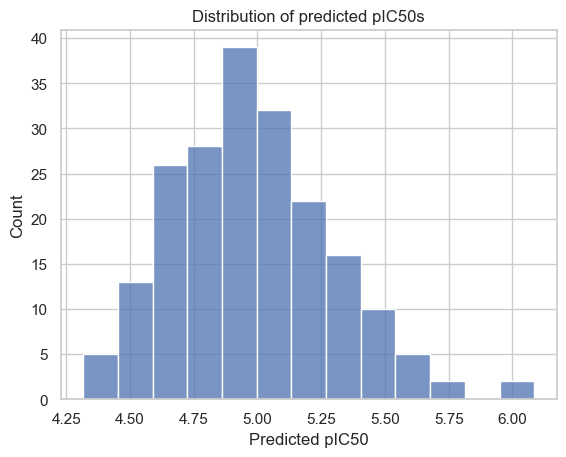

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("predictions.csv").sort_values("OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50")

plt.figure()
sns.histplot(data=df, x='OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50')
plt.xlabel("Predicted pIC50")
plt.title("Distribution of predicted pIC50s")

Now that you have an idea of what the predicted activities of your leac compounds maybe, you can sort them from highest to lowest predicted pIC50 (if that's what you're interested in) and examine the molecular structures for common motifs or functional groups. The molecular structures are displayed from most active to least active below.

In [11]:
import mols2grid

df_sorted = df.sort_values('OADMET_PRED_openadmet-chembl_OPENADMET_LOGAC50', ascending=False)
mols2grid.display(df_sorted, smiles_col="OPENADMET_CANONICAL_SMILES")

MolGridWidget()

### Estimating Model Uncertainty

While beyond the scope of this particular demo, it is worth mentioning that the OpenADMET framework also includes being able to estimate the uncertainty of a model's predictions.  

Some questions you might have about the model inference results shown above are:
> If I'm relying on my model's predictions to pick active compounds, how off can my predictions be?

> What degree of error does my model have?

> What compounds would be most informative to assay next?

This is done by training an ensemble of models, rather than a single model. This is useful for complex problems like predicting ADMET profiles of compounds, where data is sparse. Using the combined predictions of a model ensemble increases the robustness and accuracy of those predictions.  

If you're interested, visit our [Ensemble Model Training demo notebook](https://github.com/OpenADMET/openadmet-demos/tree/d4d3ed5373f494ce00139daa58b9ad162f4ce144/demos/04_Ensemble_Model_Training).

## 5. Next steps

Congratulations! You now have all the tools you need to train and apply your own ADMET models with OpenADMET!

Ready to go further?

* Join the community – Ask questions, share feedback, and discuss workflows with other users on our [GitHub Discussions](https://github.com/orgs/OpenADMET/discussions).
* Contribute – Found a bug, have a feature request, or built a new workflow? Open an issue or pull requestand help grow the ecosystem.
* Stay updated – Keep an eye on our repositories for new demos, model architectures, and tools as they’re released. Updates will appear on our [website](https://openadmet.org/)
